In [1]:
from torchvision import transforms
from torchvision.models import vgg16, resnet152, alexnet
import torch

import os
import json
from PIL import Image
import numpy as np

In [2]:
labels = json.load(open('./data/imagenet/ILSVRC/Data/CLS-LOC/val_10p/imagnet_classes.json'))

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [4]:
model = alexnet(pretrained = True)
model.eval()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [170]:
image_name = 'ILSVRC2012_val_00000157.JPEG'
i1 = './data/imagenet/ILSVRC/Data/CLS-LOC/val_10p/images/'+image_name
l1 = int(labels[image_name.split('.')[0]])


In [171]:
print(i1, l1)

./data/imagenet/ILSVRC/Data/CLS-LOC/val_10p/images/ILSVRC2012_val_00000157.JPEG 277


In [172]:
preprocessing1 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
])

preprocessing2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
])

preprocessing = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
])

img = Image.open(i1).convert('RGB')
img = preprocessing(img).unsqueeze(dim = 0)
img = img.to(device)

In [173]:
torch.argmax(model(img)).numpy(), l1, model(img)[0][370].data.numpy()

(array(277), 277, array(6.247413, dtype=float32))

In [174]:
occSize = 8
preds = np.zeros((224, 224))
img = Image.open(i1).convert('RGB')
img = np.array(preprocessing1(img))
print(img.shape)
for i in range(0, 224, occSize):
    for j in range(0, 224, occSize):
        img1 = np.array(img)
        img1[i:i+occSize, j:j+occSize, :] = 0
        img1 = Image.fromarray(img1)
        img1 = preprocessing2(img1).unsqueeze(dim = 0).to(device)
        pred = model(img1)
        pred = -pred[0][l1].detach()
        preds[i:i+occSize, j:j+occSize] = pred
        
preds = 255.*(preds-np.min(preds))/(np.max(preds)-np.min(preds))

(224, 224, 3)


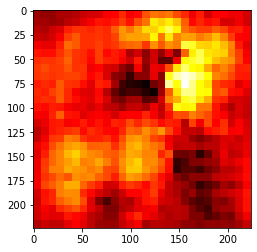

In [175]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(preds, cmap='hot', interpolation='nearest')
plt.show()

In [176]:
import cv2
map_img = np.uint8(preds)
heatmap_img = cv2.applyColorMap(map_img, cv2.COLORMAP_JET)

In [177]:
fin = cv2.addWeighted(heatmap_img, 0.4, img, 0.6, 0)

(-0.5, 223.5, 223.5, -0.5)

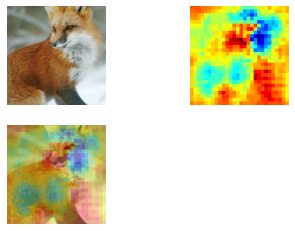

In [178]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(img)
axs[0, 1].imshow(heatmap_img, alpha = 1., cmap = plt.cm.jet)
axs[1, 0].imshow(fin, alpha = 1., cmap = plt.cm.jet)
axs[1, 1].remove()
axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[1, 0].axis('off')